In [1]:
%pylab inline --no-import-all
from sympy import Symbol, symbols, solve, lambdify
#import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=True)

In [3]:
#import matplotlib.pyplot as plt

In [4]:
#observables
(n11, n12, n21, n22) =  symbols('n11 n12 n21 n22')
#parameters
(s1, s2, b1, b2, mu) =  symbols('s1 s2 b1 b2 mu')
#helpers
(n1, n2, nu11, nu12, n21, nu22) =  symbols('n1 n2 nu11 nu12 nu21 n22')
#estimators
(s1hat, s2hat, muhat) = symbols('s1hat s2hat muhat')

In [5]:
#first run
nu11 = s1hat + b1
nu12 = s2hat + b2
#second run
nu21 = muhat*s1hat+b1
nu22 = muhat*s2hat+b2

In [6]:
#first run
shatSubs = [(key, val) for key,val in solve([n11-nu11, n12-nu12], s1hat, s2hat).iteritems()]
moreSubs = shatSubs+[(n11,10),(n12,10),(n21,10),(n22,10),(b1,5),(b2,5)]
s1hat.subs(moreSubs), s2hat.subs(moreSubs)

(5, 5)

In [7]:
#second run
[expr1, expr2] = solve( s1hat+s2hat - n21*s1hat/nu21 - n22*s2hat/nu22, muhat)

In [8]:
expr1.subs(moreSubs),expr2.subs(moreSubs)

(-1, 1)

In [9]:
muhatFunc = lambdify((n11,n12,n21,n22,b1,b2), expr2.subs(shatSubs), "numpy")
muhatFunc(10,10,10,10,5,5)

1.0

In [10]:
muhatFuncTruth = lambdify((n11,n12,n21,n22,b1,b2,s1hat,s2hat), expr2, "numpy")
muhatFuncTruth(10,10,10,10,5,5,5,5)

1.0

$Pois(n|\nu) = e^{-\nu} \nu^n/n!$

$-2 \log L(\nu) = 2*(\nu - n \ln \nu)$

$q(0) = -2 \log L(\nu)/L(\hat\nu) = 2*(\nu(0)-\hat{\nu}) - n \ln \nu(0) / \hat\nu )$

In [11]:
def inclusive_muhatFunc(n11,n12,n21,n22,b1,b2):
    shat = 1.*(n11+n12-b1-b2)+.01
    return np.maximum(-7,np.minimum(7,np.divide(n21+n22-b1-b2,shat)))

In [12]:
def q0inclusive(n11,n12,n21,n22,b1,b2):
    #shat = 1.*(n11+n12-b1-b2)+.01
    #muhat = np.divide(n21+n22-b1-b2,shat)
    return 2*(-(n21+n22-b1-b2) - (n21+n22)*np.log((b1+b2)/(n21+n22)))

In [13]:
def q0DGSS(n11,n12,n21,n22,b1,b2):
    muhat = muhatFunc(n11,n12,n21,n22,b1,b2)
    s1hat = 1.*(n11-b1)
    s2hat = 1.*(n12-b2)
    q_1 = 2*( -muhat*s1hat - (n21)*np.log((b1)/(b1+s1hat*muhat)))
    q_2 = 2*( -muhat*s2hat - (n22)*np.log((b2)/(b2+s2hat*muhat)))
    return q_1+q_2

In [14]:
def q0Truth(n11,n12,n21,n22,b1,b2,s1hat,s2hat):
    muhat = muhatFuncTruth(n11,n12,n21,n22,b1,b2,s1hat,s2hat)
    #s1hat = s1
    #s2hat = s2
    q_1 = 2*( -muhat*s1hat - (n21)*np.log((b1)/(b1+s1hat*muhat)))
    q_2 = 2*( -muhat*s2hat - (n22)*np.log((b2)/(b2+s2hat*muhat)))
    return q_1+q_2

## Generate toy experiments without Run-1 filtering

In [15]:
#b experiments, no filtering
nExp = 10000
btruth=[(b1,100),(b2,100)]
struth=[(s1hat,0),(s2hat,0),(muhat,0)]
truth=btruth+struth
n11.subs(truth),nu12.subs(truth),nu21.subs(truth),nu22.subs(truth)
n11_expts = np.random.poisson(nu11.subs(truth),nExp)
n12_expts = np.random.poisson(nu12.subs(truth),nExp)
n21_expts = np.random.poisson(nu21.subs(truth),nExp)
n22_expts = np.random.poisson(nu22.subs(truth),nExp)
muhat_b_expts = muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
muhat_b_expts = filter(lambda x: x<1e6, muhat_b_expts)
muhat_b_expts =  np.maximum(-7,np.minimum(7,muhat_b_expts))
inclusive_muhat_b_expts = inclusive_muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """


In [16]:
#s experiments, no filtering
btruth=[(b1,100),(b2,100)]
struth=[(s1hat,10*2./2.),(s2hat,10*0./2.),(muhat,1)]
truth=btruth+struth
n11.subs(truth),nu12.subs(truth),nu21.subs(truth),nu22.subs(truth)
n11_expts = np.random.poisson(nu11.subs(truth),nExp)
n12_expts = np.random.poisson(nu12.subs(truth),nExp)
n21_expts = np.random.poisson(nu21.subs(truth),nExp)
n22_expts = np.random.poisson(nu22.subs(truth),nExp)
muhat_s_expts = muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
muhat_s_expts = filter(lambda x: x<1e6, muhat_s_expts)
muhat_s_expts =  np.maximum(-7,np.minimum(7,muhat_s_expts))
inclusive_muhat_s_expts = inclusive_muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))

## Generate toy experiments *with*  Run-1 filtering

In [17]:
#b experiments, with filtering
nExp = 500000
btruth=[(b1,100),(b2,100)]
struth=[(s1hat,0),(s2hat,0),(muhat,0)]
truth=btruth+struth
n11_expts = np.random.poisson(nu11.subs(truth),nExp)
n12_expts = np.random.poisson(nu12.subs(truth),nExp)
#n21_expts = np.random.poisson(nu21.subs(truth),nExp)
#n22_expts = np.random.poisson(nu22.subs(truth),nExp)
temp = np.zeros(nExp*2).reshape(nExp,2)
temp[:,0] = n11_expts
temp[:,1] = n12_expts
#temp[:,2] = n21_expts
#temp[:,3] = n22_expts
temp = np.array(filter(lambda x: x[0]>b1.subs(truth)*1.1 and x[1]>b2.subs(truth)*1.1, temp))
n11_expts = temp[:,0]
n12_expts = temp[:,1]
#n21_expts = temp[:,2]
#n22_expts = temp[:,3]
n21_expts = np.random.poisson(nu21.subs(truth),n11_expts.size)
n22_expts = np.random.poisson(nu22.subs(truth),n11_expts.size)
len(n22_expts)
muhat_b_expts = muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
muhat_b_expts = filter(lambda x: x<1e6, muhat_b_expts)
muhat_b_expts =  np.maximum(-10,np.minimum(10,muhat_b_expts))
inclusive_muhat_b_expts = inclusive_muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
inclusive_q0_b_expts = q0inclusive(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
q0_b_expts = q0DGSS(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
nu11.subs(truth),nu12.subs(truth),nu21.subs(truth),nu22.subs(truth)

(100, 100, 100, 100)

In [18]:
#b truth experiments, need to know true signal rate
#experiments are still the b-only ones
struth=[(s1hat,50),(s2hat,1),(muhat,1)]
truth=btruth+struth
truth_q0_b_expts = q0Truth(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)),float(s1hat.subs(truth)),float(s2hat.subs(truth)))

In [19]:
np.max(truth_q0_b_expts)

15.76318163696102

In [20]:
#s experiments, with filtering
nExp = 10000
#ok, now make s+b experimentes
n11_expts = np.random.poisson(nu11.subs(truth),nExp)
n12_expts = np.random.poisson(nu12.subs(truth),nExp)
#n21_expts = np.random.poisson(nu21.subs(truth),nExp)
#n22_expts = np.random.poisson(nu22.subs(truth),nExp)
temp = np.zeros(nExp*2).reshape(nExp,2)
temp[:,0] = n11_expts
temp[:,1] = n12_expts
#temp[:,2] = n21_expts
#temp[:,3] = n22_expts
temp = np.array(filter(lambda x: x[0]>b1.subs(truth)*1.1 and x[1]>b2.subs(truth)*1.1, temp))
n11_expts = temp[:,0]
n12_expts = temp[:,1]
#n21_expts = temp[:,2]
#n22_expts = temp[:,3]
n21_expts = np.random.poisson(nu21.subs(truth),n11_expts.size)
n22_expts = np.random.poisson(nu22.subs(truth),n11_expts.size)
muhat_s_expts = muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
muhat_s_expts = filter(lambda x: x<1e6, muhat_s_expts)
muhat_s_expts =  np.maximum(-10,np.minimum(10,muhat_s_expts))
inclusive_muhat_s_expts = inclusive_muhatFunc(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
inclusive_q0_s_expts = q0inclusive(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
q0_s_expts = q0DGSS(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)))
truth_q0_s_expts = q0Truth(n11_expts,n12_expts,n21_expts,n22_expts,float(b1.subs(truth)),float(b2.subs(truth)),float(s1hat.subs(truth)),float(s2hat.subs(truth)))
nu11.subs(truth),nu12.subs(truth),nu21.subs(truth),nu22.subs(truth)
len(muhat_s_expts)

1676

shat | s = 0.920 +/- 0.094
shat | b = 0.002 +/- 0.213


(1676, 10850)

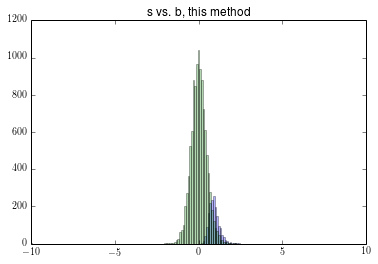

In [21]:
#s vs. b for this method
edges = np.linspace(-10,10,200)
#non uniform binning
#edges=np.append(np.arange(-10,-3,1),np.arange(-3,5,.1))
#np.append(edges,np.arange(5,10,1))
#print len(edges)
s_contents, edges, patches = plt.hist(muhat_s_expts,bins=edges,alpha=0.3,color='b')
b_contents, edges, patches = plt.hist(muhat_b_expts,bins=edges,alpha=0.3,color='g')
plt.title('s vs. b, this method')
print "shat | s = %.3f +/- %.3f" %(np.mean(muhat_s_expts), np.var(muhat_s_expts))
print "shat | b = %.3f +/- %.3f" %(np.mean(muhat_b_expts), np.var(muhat_b_expts))
np.min(muhat_b_expts),np.max(muhat_b_expts)
len(muhat_s_expts), len(muhat_b_expts)

shat | s = 0.807 +/- 0.091
shat | b = 0.001 +/- 0.217


array([-2.04259018, -1.89218136, -1.85647983, -1.82529335, -1.74927114,
       -1.70762182, -1.69165705, -1.66597251, -1.65145589, -1.59200296])

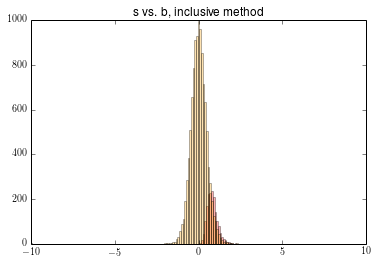

In [22]:
#s vs. b for inclusive method
i_s_contents, edges, patches = plt.hist(inclusive_muhat_s_expts,bins=edges,alpha=0.3,color='r')
i_b_contents, edges, patches = plt.hist(inclusive_muhat_b_expts,bins=edges,alpha=0.3,color='orange')
plt.title('s vs. b, inclusive method')
print "shat | s = %.3f +/- %.3f" %(np.mean(inclusive_muhat_s_expts), np.var(inclusive_muhat_s_expts))
print "shat | b = %.3f +/- %.3f" %(np.mean(inclusive_muhat_b_expts), np.var(inclusive_muhat_b_expts))
np.min(inclusive_muhat_b_expts),np.max(inclusive_muhat_b_expts)
np.sort(inclusive_muhat_b_expts)[:10] #there are lots of very negative entries
#np.sort(inclusive_muhat_b_expts)[-10:] #there are lots of very negative entries

In [23]:
#matplotlib.rcParams['figure.figsize'] = [800,800]

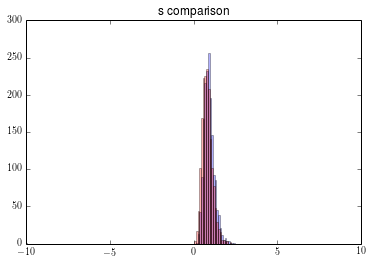

In [24]:
#compare s distributions
contents, edges, patches = plt.hist(muhat_s_expts,bins=edges,alpha=0.3,color='b')
contents, edges, patches = plt.hist(inclusive_muhat_s_expts,bins=edges,alpha=0.3,color='r')
plt.title('s comparison')

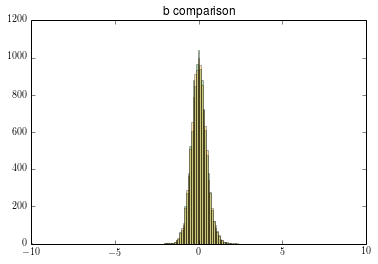

In [25]:
#compare b distributions
contents, edges, patches = plt.hist(muhat_b_expts,bins=edges,alpha=0.3,color='g')
contents, edges, patches = plt.hist(inclusive_muhat_b_expts,bins=edges,alpha=0.3,color='orange')
plt.title('b comparison')

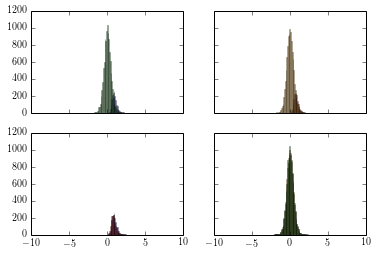

In [26]:
#figsize(600,600)
fig, ax = plt.subplots(2,2,sharex=True, sharey=True)
#plt.figure(None,figsize=(1800,1800))

contents, edges, patches = ax[0][0].hist(muhat_s_expts,bins=edges,alpha=0.3,color='b')
contents, edges, patches = ax[0][0].hist(muhat_b_expts,bins=edges,alpha=0.3,color='g')

contents, edges, patches = ax[0][1].hist(inclusive_muhat_s_expts,bins=edges,alpha=0.3,color='r')
contents, edges, patches = ax[0][1].hist(inclusive_muhat_b_expts,bins=edges,alpha=0.3,color='orange')

contents, edges, patches = ax[1][0].hist(muhat_s_expts,bins=edges,alpha=0.3,color='b')
contents, edges, patches = ax[1][0].hist(inclusive_muhat_s_expts,bins=edges,alpha=0.3,color='r')

contents, edges, patches = ax[1][1].hist(inclusive_muhat_b_expts,bins=edges,alpha=0.3,color='orange')
contents, edges, patches = ax[1][1].hist(muhat_b_expts,bins=edges,alpha=0.3,color='g')

(9.2165898617491138e-05, 1.05)

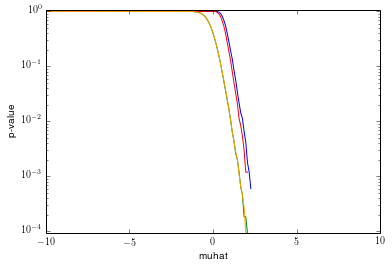

In [27]:
plt.plot(edges[:-1],1.-np.cumsum(s_contents)/np.sum(s_contents),c='b')
plt.plot(edges[:-1],1.-np.cumsum(b_contents)/np.sum(b_contents),c='g')
plt.plot(edges[:-1],1.-np.cumsum(i_s_contents)/np.sum(i_s_contents),c='r')
plt.plot(edges[:-1],1.-np.cumsum(i_b_contents)/np.sum(i_b_contents),c='orange')
plt.xlabel('muhat')
plt.ylabel('p-value')
plt.semilogy()
plt.ylim(0,1.05)

[]

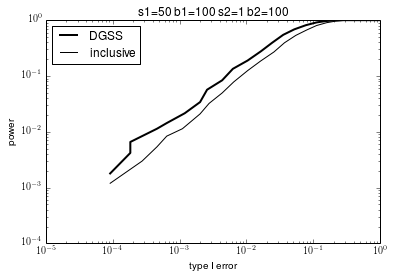

In [28]:
plt.plot(1.-np.cumsum(b_contents)/np.sum(b_contents),1.-np.cumsum(s_contents)/np.sum(s_contents),c='black',lw=2)
plt.plot(1.-np.cumsum(i_b_contents)/np.sum(i_b_contents),1.-np.cumsum(i_s_contents)/np.sum(i_s_contents),c='black',lw=1)
plt.xlabel('type I error')
plt.ylabel('power')
plt.title('s1=%d b1=%d s2=%d b2=%d' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
plt.legend(('DGSS', 'inclusive'),loc='upper left' )
plt.loglog()
#plt.savefig("power_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

Notes to self:

current filtering is s1hat >0 and s2hat > 0. Instead we might want cumulative n1+n2-b1-b2>0, but then need to make this method ignore bin if sihat<0.

Might want to cut harder than 0

muhat not best test statistic. If shat small and n2-b2 also small, can get muhat large. Should move to lambda(0).


In [29]:
testSize=0.01

13.2555468334 1.28031871018


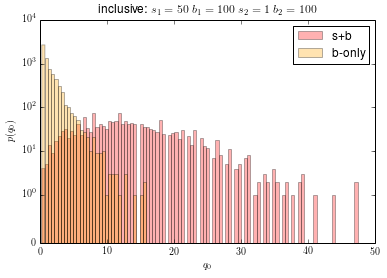

In [30]:
pylab.yscale('symlog',linthreshy=1) #works for histograms
i_s_contents, edges, patches = plt.hist(inclusive_q0_s_expts,normed=False, bins=100, alpha=0.3, color='r')
i_b_contents, edges, patches = plt.hist(inclusive_q0_b_expts,normed=False, bins=edges, alpha=0.3, color='orange')
i_s_cumsum = np.cumsum(i_s_contents)/np.sum(i_s_contents)
i_b_cumsum = np.cumsum(i_b_contents)/np.sum(i_b_contents)
i_index = np.searchsorted(i_b_cumsum,1.-testSize)
print np.mean(inclusive_q0_s_expts), np.var(inclusive_q0_s_expts)/np.sqrt(inclusive_q0_s_expts.size)
plt.xlabel('$q_0$')
plt.ylabel('$p( q_0 )$')
plt.legend(('s+b', 'b-only'),loc='upper right')
plt.title('inclusive: $s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
#plt.ylim(1e-4,1)
plt.savefig("q0_dist_incl_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

20.8745958606 2.22562078746


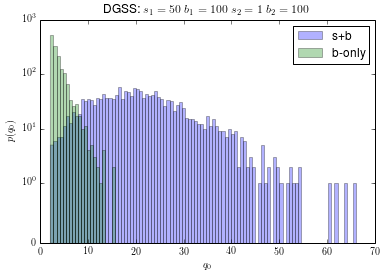

In [34]:
pylab.yscale('symlog',linthreshy=1) #works for histograms
s_contents, edges, patches = plt.hist(q0_s_expts, bins=100, alpha=0.3, color='b')
b_contents, edges, patches = plt.hist(q0_b_expts, bins=edges, alpha=0.3, color='g')
s_cumsum = np.cumsum(s_contents)/np.sum(s_contents)
b_cumsum = np.cumsum(b_contents)/np.sum(b_contents)
index = np.searchsorted(b_cumsum,1.-testSize)
print np.mean(q0_s_expts), np.var(q0_s_expts)/np.sqrt(q0_s_expts.size)
plt.xlabel('$q_0$')
plt.ylabel('$p( q_0 )$')
plt.legend(('s+b', 'b-only'),loc='upper right')
plt.title('DGSS: $s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
plt.savefig("q0_dist_DGSS_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

23.0774493425 2.43643106026


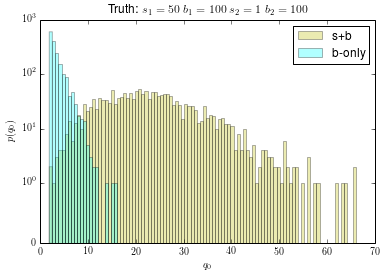

In [36]:
pylab.yscale('symlog',linthreshy=1) #works for histograms
truth_s_contents, edges, patches = plt.hist(truth_q0_s_expts, bins=100, alpha=0.3, color='y')
truth_b_contents, edges, patches = plt.hist(truth_q0_b_expts, bins=edges, alpha=0.3, color='cyan')
truth_s_cumsum = np.cumsum(truth_s_contents)/np.sum(truth_s_contents)
truth_b_cumsum = np.cumsum(truth_b_contents)/np.sum(truth_b_contents)
truth_index = np.searchsorted(truth_b_cumsum,1.-testSize)
print np.mean(truth_q0_s_expts), np.var(truth_q0_s_expts)/np.sqrt(truth_q0_s_expts.size)
plt.xlabel('$q_0$')
plt.ylabel('$p( q_0 )$')
plt.legend(('s+b', 'b-only','other'),loc='upper right')
plt.title('Truth: $s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
plt.savefig("tq0_dist_truth_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

In [38]:
i_index, index, truth_index

(15, 13, 11)

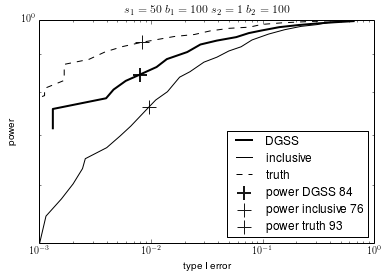

In [48]:
plt.plot(1.-b_cumsum,1.-s_cumsum,c='black',lw=2)
plt.plot(1.-i_b_cumsum,1.-i_s_cumsum,c='black',lw=1)
plt.plot(1.-truth_b_cumsum,1.-truth_s_cumsum,c='black',lw=1,ls='--')
plt.scatter(1.-b_cumsum[index],1.-s_cumsum[index],alpha=0.9,marker='+',s=200,lw=2, c='black')
plt.scatter(1.-i_b_cumsum[i_index],1.-i_s_cumsum[i_index],alpha=0.9,marker='+',s=200,c='black')
plt.scatter(1.-truth_b_cumsum[truth_index],1.-truth_s_cumsum[truth_index],alpha=0.9,marker='+',s=200,c='black')
power_DGSS=100*(1.-s_cumsum[index])
power_inclusive=100*(1.-i_s_cumsum[i_index])
power_truth=100*(1.-truth_s_cumsum[truth_index])
lab_power_DGSS='power DGSS %.0f %%' %(power_DGSS)
lab_power_inclusive='power inclusive %.0f%%' %(power_inclusive)
lab_power_truth='power truth %.0f%%' %(power_truth)
plt.xlabel('type I error')
plt.ylabel('power')
plt.title('$s_1=%d$ $b_1=%d$ $s_2=%d$ $b_2=%d$' %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))
plt.legend(('DGSS', 'inclusive','truth',lab_power_DGSS,lab_power_inclusive,lab_power_truth),loc='lower right', scatterpoints=1 )
plt.ylim(5e-1,1)
plt.xlim(1e-3,1)
plt.loglog()
plt.savefig("q0_power_s1_%d_b1_%d_s2_%d_b2_%d.pdf" %(s1hat.subs(struth),b1.subs(btruth), s2hat.subs(struth),b2.subs(btruth),))

(9.2242413061494055e-05, 1.05)

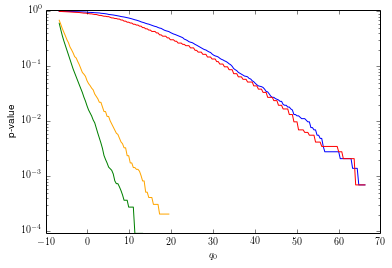

In [386]:
plt.plot(edges[:-1],1.-s_cumsum,c='b')
plt.plot(edges[:-1],1.-b_cumsum,c='g')
plt.plot(edges[:-1],1.-i_s_cumsum,c='r')
plt.plot(edges[:-1],1.-i_b_cumsum,c='orange')
plt.xlabel('$q_0$')
plt.ylabel('p-value')
plt.semilogy()
plt.ylim(0,1.05)

## Notes:

For bi=100, s1=25, s2=0, the b-only q0 distributions aren't the same, one of them isn't a chi^2. Probably DGSS distribution - numerator is invariant, but denominator of both depends on shat... but seems like inclusive approach probaby just soem rescailing while DGSS depends on n11/n12.  Didn't see that for s1=50, why would b-only depend?

In [371]:
#np.searchsorted?

In [372]:
#plt.legend?